In [1]:
import os
import numpy as np
from medmnist import INFO, Evaluator, RetinaMNIST, DermaMNIST, BloodMNIST
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as dset
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms, datasets
import torchvision.transforms.functional as F
from torchvision import datasets, transforms, models
from torchvision.transforms import transforms
from torchvision import transforms as T
from torch.optim.optimizer import Optimizer, required
import re
import pickle as pk
from PIL import Image
import random
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, f1_score
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score
import matplotlib.pyplot as plt


In [2]:
np.random.seed(16)
torch.manual_seed(16)


class ContrastiveLearningViewGenerator(object):
    def __init__(self, base_transform, n_views=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transform(x) for i in range(self.n_views)]

def set_seed(seed = 16):
    np.random.seed(16)
    
    torch.manual_seed(16)

class ContrastiveLearningDataset:
    def __init__(self, root_folder):
        self.root_folder = root_folder

    @staticmethod
    def get_simclr_pipeline_transform(size, s=1):
        color_jitter = transforms.ColorJitter(0.9 * s, 0.9 * s, 0.9 * s, 0.2 * s)
        data_transforms = transforms.Compose([transforms.RandomResizedCrop(size=size, scale=(0.8, 1.0)),
                                              transforms.ToTensor()])
        return data_transforms

    def get_dataset(self, name, n_views):
        valid_datasets = {'retina': lambda: RetinaMNIST(split='train', transform=ContrastiveLearningViewGenerator(
                                                                  self.get_simclr_pipeline_transform(28)), download=True),
                        'bloodmnist': lambda: BloodMNIST(split='train', transform=ContrastiveLearningViewGenerator(
                                                                  self.get_simclr_pipeline_transform(28)), download=True),
                        'dermamnist': lambda: DermaMNIST(split='train', transform=ContrastiveLearningViewGenerator(
                                                                  self.get_simclr_pipeline_transform(28)), download=True),}
        dataset_fn = valid_datasets[name]
        return dataset_fn()

dataset = ContrastiveLearningDataset('retina')
train_dataset = dataset.get_dataset('retina', 2)
images = train_dataset.imgs
labels = train_dataset.labels
#medloader
class ContrastiveLearningDataset:
    def __init__(self, root_folder):
        self.root_folder = root_folder

    @staticmethod
    def get_simclr_pipeline_transform(size, s=1):
        color_jitter = transforms.ColorJitter(0.9 * s, 0.9 * s, 0.9 * s, 0.2 * s)
        data_transforms = transforms.Compose([transforms.RandomResizedCrop(size=size, scale=(0.8, 1.0)),
                                              transforms.ToTensor()])
        return data_transforms

    def get_dataset(self, name, n_views):
        valid_datasets = {'retina': lambda: RetinaMNIST(split='val', transform=ContrastiveLearningViewGenerator(
                                                                  self.get_simclr_pipeline_transform(28)), download=True),
                        'bloodmnist': lambda: BloodMNIST(split='val', transform=ContrastiveLearningViewGenerator(
                                                                  self.get_simclr_pipeline_transform(28)), download=True),
                        'dermamnist': lambda: DermaMNIST(split='val', transform=ContrastiveLearningViewGenerator(
                                                                  self.get_simclr_pipeline_transform(28)), download=True),}
        dataset_fn = valid_datasets[name]
        return dataset_fn()

dataset2 = ContrastiveLearningDataset('retina')
test_dataset=dataset2.get_dataset('retina', 2)

testimages=test_dataset.imgs
testlabels=test_dataset.labels

#medloader
class ContrastiveLearningDataset:
    def __init__(self, root_folder):
        self.root_folder = root_folder

    @staticmethod
    def get_simclr_pipeline_transform(size, s=1):
        color_jitter = transforms.ColorJitter(0.9 * s, 0.9 * s, 0.9 * s, 0.2 * s)
        data_transforms = transforms.Compose([transforms.RandomResizedCrop(size=size, scale=(0.8, 1.0)),
                                              transforms.ToTensor()])
        return data_transforms

    def get_dataset(self, name, n_views):
        valid_datasets = {'retina': lambda: RetinaMNIST(split='test', transform=ContrastiveLearningViewGenerator(
                                                                  self.get_simclr_pipeline_transform(28)), download=True),
                        'bloodmnist': lambda: BloodMNIST(split='test', transform=ContrastiveLearningViewGenerator(
                                                                  self.get_simclr_pipeline_transform(28)), download=True),
                        'dermamnist': lambda: DermaMNIST(split='test', transform=ContrastiveLearningViewGenerator(
                                                                  self.get_simclr_pipeline_transform(28)), download=True),}
        dataset_fn = valid_datasets[name]
        return dataset_fn()

dataset3 = ContrastiveLearningDataset('retina')
last_dataset=dataset3.get_dataset('retina', 2)

lastimage=last_dataset.imgs
lastlabels=last_dataset.labels

images = np.moveaxis(images,3,1)
testimages = np.moveaxis(testimages,3,1)
lastimage= np.moveaxis(lastimage,3,1)

images = images.astype(np.float)
testimages = testimages.astype(np.float)
lastimage = lastimage.astype(np.float)

trimages = np.moveaxis(images,1,3)
tsimages = np.moveaxis(testimages,1,3)
tlastimages = np.moveaxis(lastimage,1,3)
print('image shape: ------')
print(trimages.shape, tsimages.shape, tlastimages.shape)

labels = labels.astype(np.int)
testlabels = testlabels.astype(np.int)
tlastlabels = lastlabels.astype(np.int)

MEAN = np.mean(images/255.0,axis=(0,2,3),keepdims=True)
STD = np.std(images/255.0,axis=(0,2,3),keepdims=True)

set_seed(16)

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

class LinearLayer(nn.Module):
    def __init__(self,
                 in_features,
                 out_features,
                 use_bias = True,
                 use_bn = False,
                 **kwargs):
        super(LinearLayer, self).__init__(**kwargs)

        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = use_bias
        self.use_bn = use_bn
        
        self.linear = nn.Linear(self.in_features, 
                                self.out_features, 
                                bias = self.use_bias and not self.use_bn)
        if self.use_bn:
             self.bn = nn.BatchNorm1d(self.out_features)

    def forward(self,x):
        x = self.linear(x)
        if self.use_bn:
            x = self.bn(x)
        return x

class ProjectionHead(nn.Module):
    def __init__(self,
                 in_features,
                 hidden_features,
                 out_features,
                 head_type = 'nonlinear',
                 **kwargs):
        super(ProjectionHead,self).__init__(**kwargs)
        self.in_features = in_features
        self.out_features = out_features
        self.hidden_features = hidden_features
        self.head_type = head_type

        if self.head_type == 'linear':
            self.layers = LinearLayer(self.in_features,self.out_features,False, True)
        elif self.head_type == 'nonlinear':
            self.layers = nn.Sequential(
                LinearLayer(self.in_features,self.hidden_features,True, True),
                nn.ReLU(),
                LinearLayer(self.hidden_features,self.out_features,False,True))
        
    def forward(self,x):
        x = self.layers(x)
        return x

class PreModel(nn.Module):
    def __init__(self,base_model):
        super().__init__()
        self.base_model = base_model

        self.pretrained = models.resnet18(pretrained=True)
        
        self.pretrained.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
        self.pretrained.maxpool = Identity()
        
        self.pretrained.fc = Identity()
        
        for p in self.pretrained.parameters():
            p.requires_grad = True
        
        self.projector = ProjectionHead(512, 512, 128)
    

    def forward(self,x):
        out = self.pretrained(x)
        
        xp = self.projector(torch.squeeze(out))
        
        return xp

model = PreModel('resnet18')
model = model.to('cuda:0')

x = np.random.random((28,3,224,224))

out = model(torch.tensor(x, device = 'cuda:0', dtype = torch.float32))

EETA_DEFAULT = 0.001

Using downloaded and verified file: /home/yanankristin.qi001/.medmnist/retinamnist.npz
Using downloaded and verified file: /home/yanankristin.qi001/.medmnist/retinamnist.npz
Using downloaded and verified file: /home/yanankristin.qi001/.medmnist/retinamnist.npz
image shape: ------
(1080, 28, 28, 3) (120, 28, 28, 3) (400, 28, 28, 3)


/home/yanankristin.qi001/.conda/envs/flask/lib/python3.7/site-packages/ipykernel_launcher.py:103: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/yanankristin.qi001/.conda/envs/flask/lib/python3.7/site-packages/ipykernel_launcher.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/yanankristin.qi001/.conda/envs/flask/lib/python3.7

In [3]:
class ftmodel(nn.Module):
    def __init__(self,premodel,num_classes):
        super().__init__()
        
        self.premodel = premodel
        
        self.num_classes = num_classes
        for p in self.premodel.parameters():
            p.requires_grad = True
            
        for p in self.premodel.projector.parameters():
            p.requires_grad = True
        
        
        self.lastlayer = nn.Linear(512,self.num_classes)
        

        
    def forward(self,x):
        out = self.premodel.pretrained(x)
        
        out = self.lastlayer(out)
        return out



In [4]:
set_seed(16)
NUM_CLASSES = 5
ftmodel = ftmodel(model, NUM_CLASSES).to('cuda:0')

In [5]:
class FTData(Dataset):
    def __init__(self, phase, imgarr,labels,num_classes=NUM_CLASSES):
        
        self.phase = phase
        self.num_classes = num_classes
        self.imgarr = imgarr
        self.labels = labels
        
        self.indices = list(range(self.imgarr.shape[0]))
        
        self.randomcrop = transforms.RandomResizedCrop(28,(0.8,1.0))
    
    def __len__(self):
        return self.imgarr.shape[0]
    
    def __getitem__(self,idx):
        
        x = self.imgarr[idx]
        
        img = torch.from_numpy(x).float()
            
        label = self.labels[idx]

        if self.phase == 'train':
            img  = self.randomcrop(img)

        img = self.preprocess(img)

        
        return img, label
    
    def on_epoch_end(self):
        idx = random.sample(population = list(range(self.__len__())),k = self.__len__())
        self.imgarr = self.imgarr[idx]
        self.labels = self.labels[idx]
        
    def preprocess(self,frame):
        frame = frame / 255.0
        frame = (frame-MEAN)/STD
        
        return frame

In [8]:
mean = [0.39838942, 0.24472671, 0.15575321]
std = [0.29828646, 0.20048242, 0.15065953]
trimages = images
valimages = lastimage
trlabels =  labels
vallabels = lastlabels
dg = FTData('train', trimages,trlabels, num_classes=NUM_CLASSES)
dl = DataLoader(dg,batch_size = 1024, drop_last = True)

vdg = FTData('valid', valimages, vallabels,num_classes=NUM_CLASSES)
vdl = DataLoader(vdg,batch_size = 1024, drop_last = True)
dataloaders_dict = {'train': dl}

In [9]:
from torch.nn.parameter import Parameter
def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = Parameter(torch.ones(1)*p)
        self.eps = eps
    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)       
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'
model.avg_pool = GeM()

In [10]:
dsoptimizer = torch.optim.SGD([params for params in ftmodel.parameters() if params.requires_grad],lr = 0.01, momentum = 0.9)
checkpoint = torch.load('/home/yanankristin.qi001/backend/retina_finetune_200_1127_after_changetrue.pt')
ftmodel.load_state_dict(checkpoint['model_state_dict'])
dsoptimizer.load_state_dict(checkpoint['optimizer_state_dict'])


In [11]:
import pickle as pk
save_path = './retinas_extract'

def save_data(file, data):
    f = open(file, 'wb+')
    pk.dump(data, f, 0)
    f.close()


def extract_features(ftmodel, dataloaders):
    res = []  
    ftmodel.eval()

    for x,y in dl:
        x = x.squeeze().to(device = 'cuda:0', dtype = torch.float)
        y = torch.flatten(y)
        y = y.to(device = 'cuda:0')    
        z = ftmodel(x)
        dsoptimizer.zero_grad()
        outputs = torch.exp(z.cpu().data)/torch.sum(torch.exp(z.cpu().data))
        res.append(outputs)
    
    return res

if os.path.exists(save_path):
    fo = open(save_path, 'rb')
    features = pk.load(fo, encoding='bytes')
    fo.close()
    print("Load features...")
else:
    features = extract_features(ftmodel, dataloaders_dict)
    save_data(save_path, features)
    print("Save features %s" % (save_path))

Save features ./retinas_extract


In [12]:
def compute_cosine(data1, data2):
    csi = np.dot(data1, data2.T) / (np.linalg.norm(data1) * (np.linalg.norm(data2)))
    return csi[0]

def search_similar(target, database):
    record = []
    for i in range(len(database)):
        for j in range(len(database[i])):
            record.append( compute_cosine(target, database[i][j].to('cpu').data.numpy()) )
    return record

In [13]:
def pred(input):
    x = input.float()
    x = x.unsqueeze(dim=0)
    x.requires_grad = False

    x.to(device = 'cuda:0')
    ftmodel.to('cpu')
    ftmodel.eval()
    #z = ftmodel(x)
    pre = ftmodel(x)
    dsoptimizer.zero_grad()
    pre = pre.data.numpy()
    #pre = torch.exp(z.cpu().data)/torch.sum(torch.exp(z.cpu().data))
    
    return pre

In [14]:
def tensor2image(data):
    for i in range(len(data)):
        data[i] = data[i] * std[i] + mean[i]
    #img = transforms.ToPILImage()(np.squeeze(data)).convert('RGB')
    img = transforms.ToPILImage()(data).convert('RGB')
    plt.imshow(img)

groundtruth label: [2]
searched label : [2] [3] [3] [3] [3] [3] [2] [3] [4] 

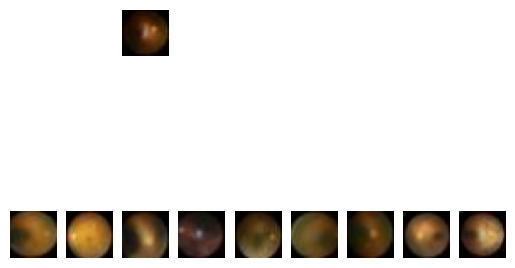

groundtruth label: [2]
searched label : [0] [3] [0] [2] [3] [2] [3] [0] [3] 

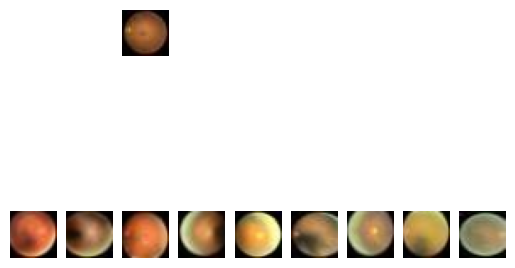

groundtruth label: [3]
searched label : [3] [0] [0] [4] [0] [3] [4] [0] [4] 

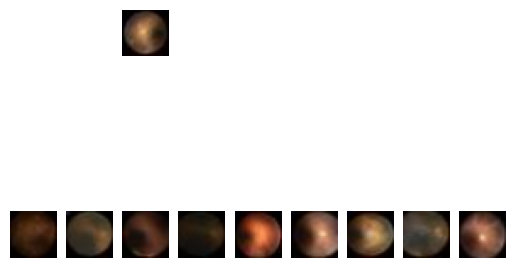

groundtruth label: [4]
searched label : [0] [0] [3] [0] [1] [0] [0] [1] [0] 

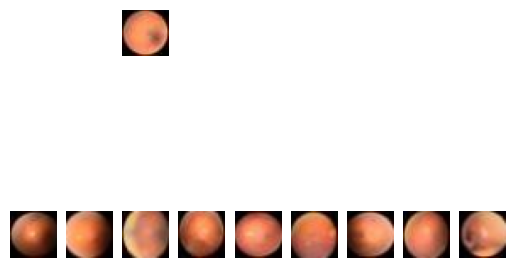

groundtruth label: [0]
searched label : [0] [3] [0] [0] [0] [0] [0] [0] [3] 

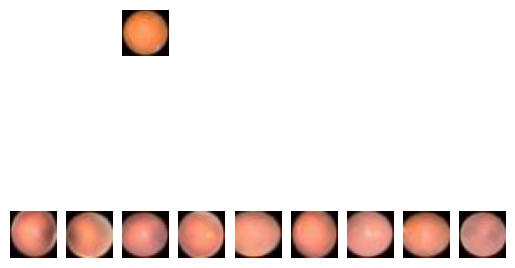

groundtruth label: [0]
searched label : [0] [0] [0] [0] [0] [0] [0] [0] [0] 

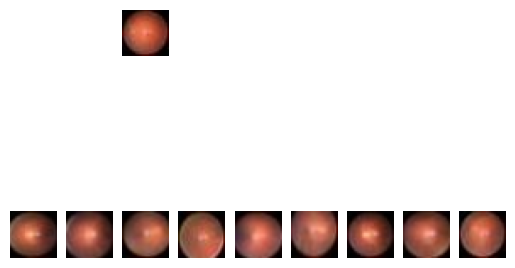

groundtruth label: [0]
searched label : [0] [0] [0] [0] [2] [0] [0] [0] [0] 

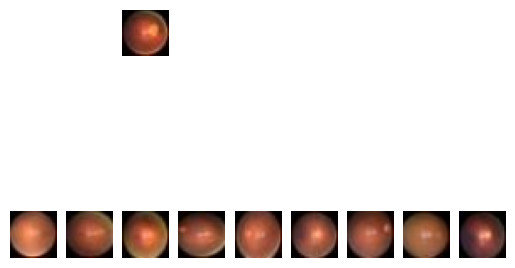

groundtruth label: [0]
searched label : [3] [2] [3] [3] [2] [2] [3] [3] [3] 

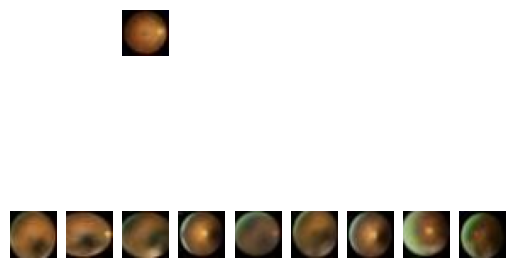

groundtruth label: [4]
searched label : [0] [2] [0] [3] [1] [0] [3] [3] [3] 

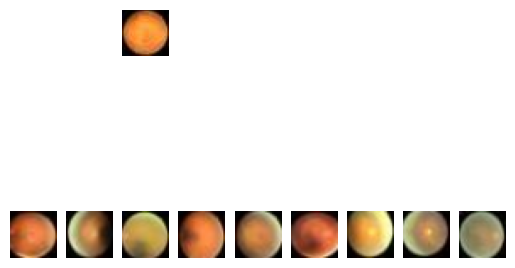

groundtruth label: [1]
searched label : [3] [3] [3] [3] [0] [0] [3] [2] [2] 

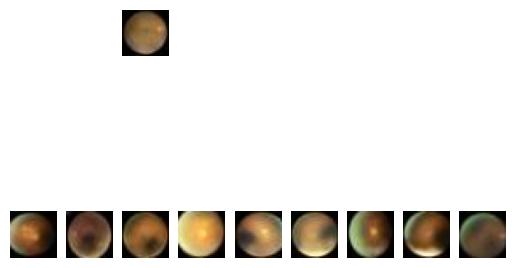

groundtruth label: [0]
searched label : [0] [0] [2] [0] [0] [0] [0] [0] [0] 

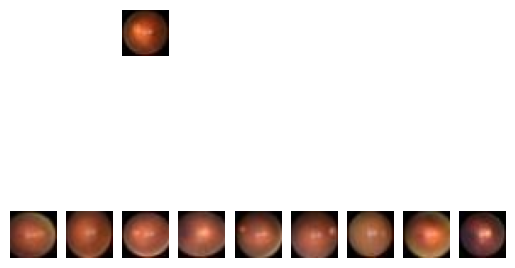

groundtruth label: [2]
searched label : [2] [3] [2] [2] [2] [3] [3] [3] [3] 

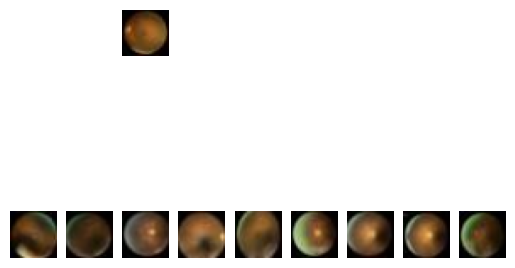

groundtruth label: [0]
searched label : [3] [3] [2] [2] [3] [3] [3] [2] [2] 

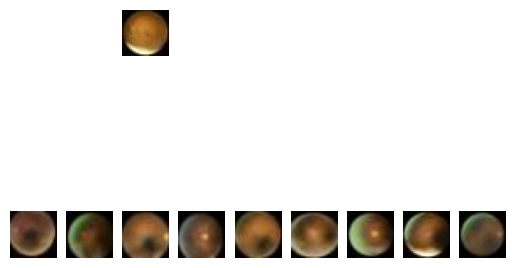

groundtruth label: [0]
searched label : [0] [0] [0] [0] [0] [0] [0] [0] [0] 

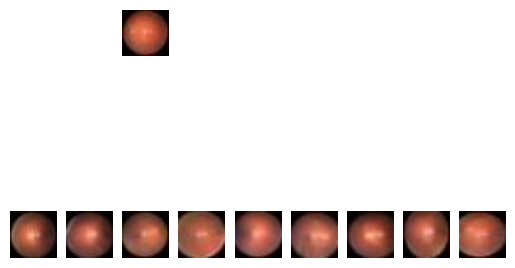

groundtruth label: [3]
searched label : [2] [2] [0] [0] [2] [3] [3] [3] [1] 

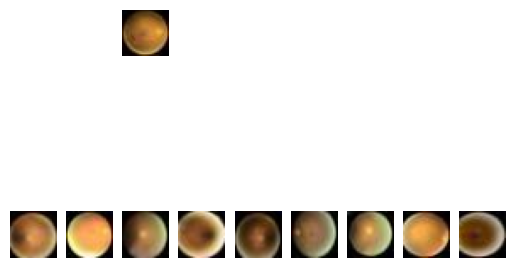

groundtruth label: [3]
searched label : [3] [2] [3] [0] [0] [3] [2] [3] [0] 

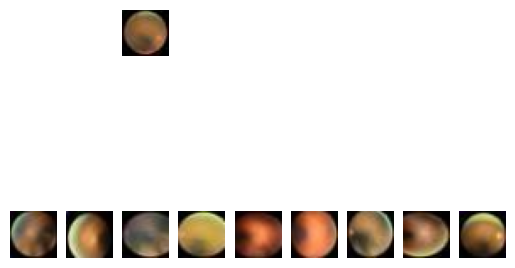

groundtruth label: [2]
searched label : [2] [2] [2] [3] [3] [3] [2] [3] [3] 

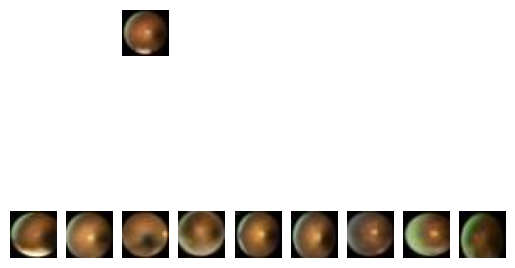

groundtruth label: [3]
searched label : [3] [3] [2] [2] [2] [2] [3] [3] [3] 

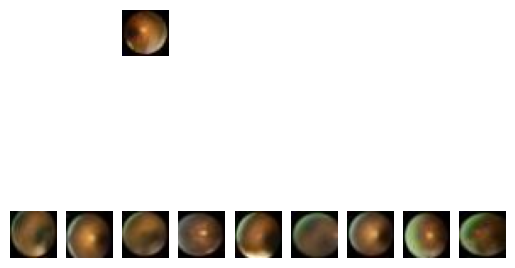

groundtruth label: [0]
searched label : [0] [0] [0] [0] [2] [0] [0] [0] [0] 

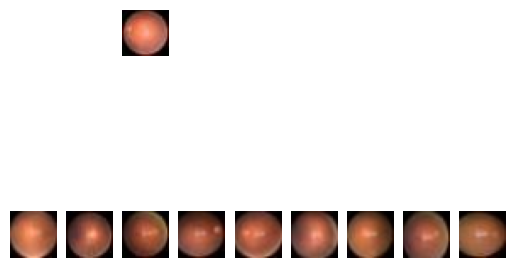

groundtruth label: [4]
searched label : [1] [2] [3] [1] [3] [2] [1] [0] [1] 

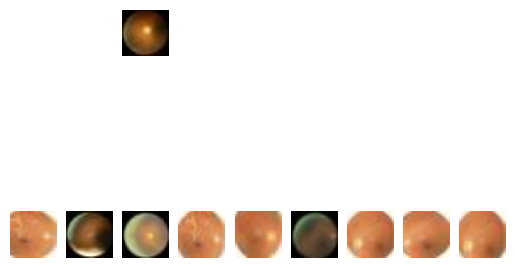

In [15]:
np.random.seed(16)
for _ in range(20):
    k = random.randint(0, len(vdg))   
    
    print("groundtruth label:", vdg[k][1])
    plt.subplot(293)
    tensor2image(np.squeeze(vdg[k][0]))
    plt.axis('off')
    
    pre = pred(np.squeeze(vdg[k][0]))
    res = search_similar(pre, features)
    sim = np.argsort(res)[-9:]   

    i = 10
    print('searched label : ',end='')
    for re in sim:
        plt.subplot(2, 9, i)      
        tensor2image(np.squeeze(dg[re][0]))
        print('%s ' % (dg[re][1]),end='')
        i += 1
        plt.axis('off')
    plt.show()